# Polarization in Voyager signal from Green Bank Telescope

Here we extract the carrier signal from Voyager 1 from a recording done at Green Bank Telescope during the Breakthrough Listen experiment. We compute the Stokes parameters for the signal.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import collections

# Larger figure size
fig_size = [12, 9]
plt.rcParams['figure.figsize'] = fig_size

plt.rcParams['agg.path.chunksize'] = 10000 # avoids error on plots with many lines https://github.com/matplotlib/matplotlib/issues/5907

The raw recordings from Green Bank Telescope can be downladed from the [Breakthrough Listen Open Data Archive](http://www.breakthroughinitiatives.org/OpenDataSearch). Here we are using [this recording](https://storage.googleapis.com/gbt_guppi/blc3_guppi_57386_VOYAGER1_0004.0000.raw), which was made on 2015-12-30 00:00:00. You can find an [analysis of this recording](https://github.com/UCBerkeleySETI/breakthrough/blob/master/GBT/voyager/voyager.ipynb) in the [breakthrough Github repository](https://github.com/UCBerkeleySETI/breakthrough).

The raw recordings are in GUPPI format. Below we have a simple class to read this format. For simplicity, the metadata of the file has to be specified, instead of being read from the file headers. A more complete implementation of a GUPPI file reader can be found [here](https://github.com/UCBerkeleySETI/blimpy/blob/master/blimpy/guppi.py).

In [2]:
class GuppiFile():
    """A class to read data from a file in GUPPI format"""
    # we only support 8bit files
    def __init__(self, filename, header_len, blocsize, npol, nchan, centre_freq, chan_bw):
        self.f = open(filename, 'rb')
        self.header_len = header_len
        self.blocsize = blocsize
        self.npol = npol
        self.nchan = nchan
        self.ntime = blocsize // (2 * npol * nchan)
        self.centre_freq = centre_freq
        self.chan_bw = chan_bw
        self.chan_len = 2 * npol * self.ntime
    
    def get_channel(self, freq):
        """Return the channel number to which the frequency freq (in Hz) belongs"""
        return self.nchan - 1 - int((freq - self.centre_freq + self.chan_bw * self.nchan // 2) / self.chan_bw)
    
    def read_block_from_channel(self, block, channel):
        """Read and return a given block from a channel"""
        self.f.seek((block + 1) * self.header_len + (block * self.nchan  + channel) * self.chan_len)
        b = np.fromfile(self.f, dtype = np.int8, count = self.chan_len)
        b = b[::2] - 1j * b[1::2] # Convert to complex and invert frequency
        return b.reshape((self.npol, self.ntime), order = 'F')
    
    def centre_frequency(self, channel):
        """Return the centre frequency for a given channel"""
        return self.centre_freq + (self.nchan // 2 - channel) * self.chan_bw

To run the code below, make sure that you have downloaded the GUPPI file and placed it in the same folder as this notebook. This opens the GUPPI file with the correct parameters.

In [3]:
guppi = GuppiFile('blc3_guppi_57386_VOYAGER1_0004.0000.raw',
                  header_len = 0x1900, blocsize = 132251648,
                  npol = 2, nchan = 64,
                  centre_freq = 8493.75e6,
                  chan_bw = 2.9296875e6)

voyager_freq = 8420.2164537e6
voyager_chan = guppi.get_channel(voyager_freq)

Now we read the first 50 blocks of the file, compute an FFT around the frequency of the Voyager 1 signal and show the power spectrums for both polarizations. Note that the Voyager 1 signal is left circularly polarized, so all the signal is in the first plot. The carrier and data sidebands are visible.

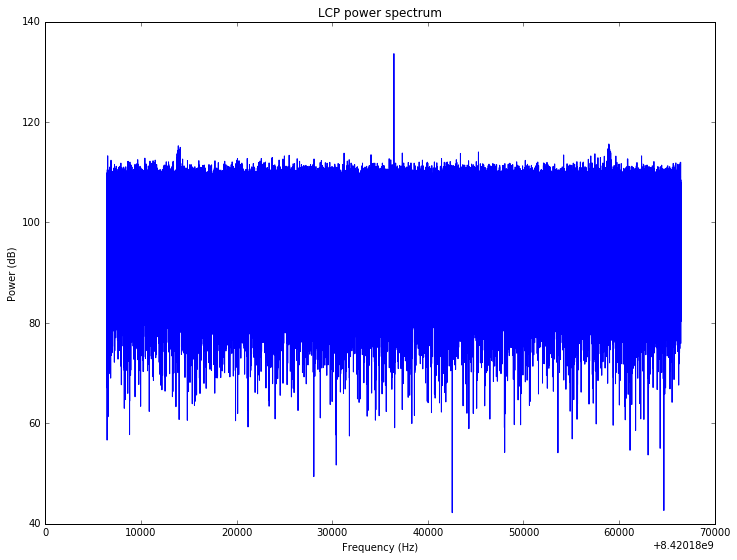

In [4]:
signal = np.concatenate([guppi.read_block_from_channel(x, voyager_chan) for x in range(50)], axis = 1)
nsamples = signal.shape[1]

# Amplitude balance between channels (to be used later)
amplitude_balance = np.sqrt(np.sum(np.abs(signal)**2, axis = 1))[::-1]

hz_per_bin = guppi.chan_bw / nsamples
centre_bin = nsamples // 2 + round((voyager_freq - guppi.centre_frequency(voyager_chan))/hz_per_bin)
width = 60e3
bin_range = round(width/2/hz_per_bin)

window = np.hamming(nsamples)
fft = np.fft.fftshift(np.fft.fft(signal * window), axes = 1)[..., centre_bin - bin_range : centre_bin + bin_range]

# delete unneeded variables to free some RAM
del signal
del window

power_spectrum = np.abs(fft)**2
frequencies = np.fft.fftshift(np.fft.fftfreq(nsamples, 1/guppi.chan_bw))[centre_bin - bin_range : centre_bin + bin_range] + guppi.centre_frequency(voyager_chan)
plt.title('LCP power spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.plot(frequencies, 10 * np.log10(power_spectrum[0,...]));

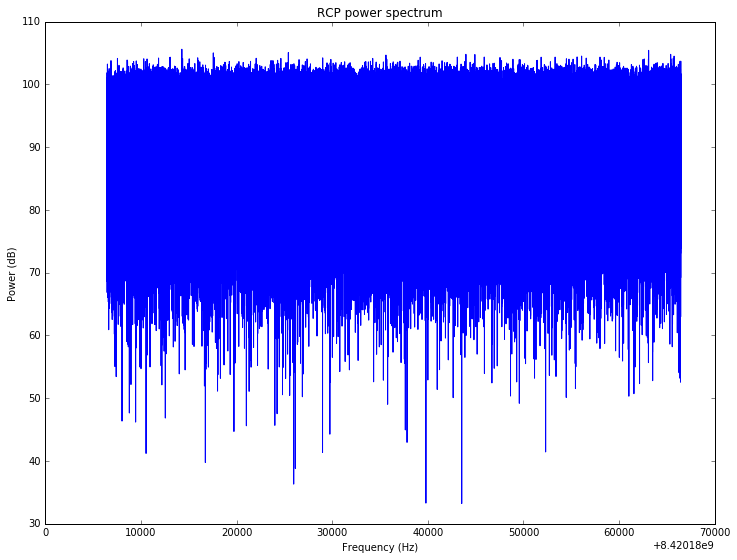

In [5]:
plt.title('RCP power spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.plot(frequencies, 10 * np.log10(power_spectrum[1,...]));

Note that the two polarization channels have different gain. The noise floor in the left channel is around 110dB, while the noise floor in the right channel is around 100dB. To compensate for this, we multiply each channel by the average power of the other channel. This ensures that both channels have the same power.

In [6]:
corrected_fft = np.array(np.diag(amplitude_balance) * np.mat(fft))
del fft

Now we select a frequency range of 10Hz about the Voyager carrier. We will compute the Stokes parameters using this frequency range as a signal in the frequency domain.

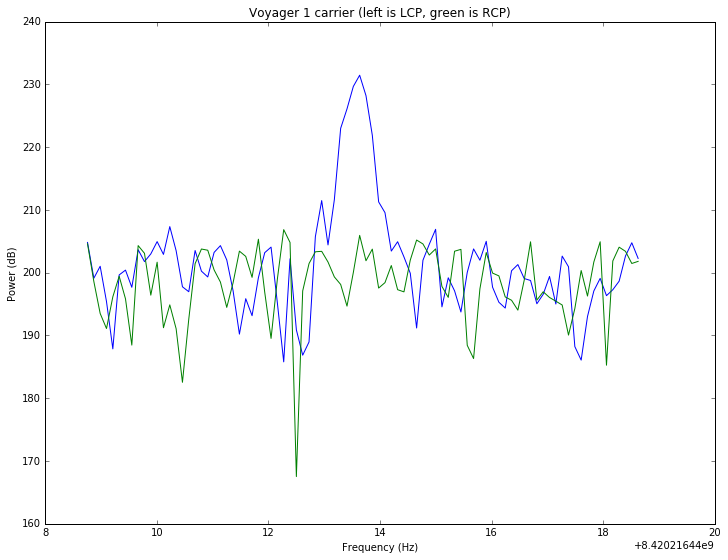

In [7]:
width = 10
selection = np.logical_and(voyager_freq - width/2 <= frequencies, frequencies <= voyager_freq + width/2)
plt.title('Voyager 1 carrier (left is LCP, green is RCP)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.plot(frequencies[selection], 20 * np.log10(np.abs(corrected_fft)[0,...][selection]))
plt.plot(frequencies[selection], 20 * np.log10(np.abs(corrected_fft)[1,...][selection]));

The class below computes the Stokes parameters of a signal in (LCP, RCP) polarization. The signal can be in the time domain or in the frequency domain.

In [8]:
StokesParameters = collections.namedtuple('StokesParameters', ['I', 'Q', 'U', 'V'])

def compute_stokes_LR(x):
    """Compute stokes parameters of signal in time or frequency domain in dual (LCP,RCP) polarization"""
    def combine_powers(x, coeffs):
        return np.dot(np.sum(np.abs(x)**2, axis = 1), coeffs)
    def transform(A, x):
        return np.array(A * np.mat(x))
    
    V_to_Q = np.matrix([[1/np.sqrt(2), 1/np.sqrt(2)], [1/(1j*np.sqrt(2)), -1/(1j*np.sqrt(2))]])
    Q_to_U = np.matrix([[1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), -1/np.sqrt(2)]])
    
    I = combine_powers(x, [1,1])
    V = combine_powers(x, [1,-1])
    Q = combine_powers(transform(V_to_Q, x), [1,-1])
    U = combine_powers(transform(Q_to_U*V_to_Q, x), [1,-1])
    
    return StokesParameters(I,Q, U, V)

We use the class above to compute the Stokes parameters of the Voyager 1 carrier. We expect to obtain parameters matching those of a LCP signal (V positive and near I, Q and U small).

In [9]:
stokes = compute_stokes_LR(corrected_fft[...,selection])
stokes

StokesParameters(I=4.0083096878627821e+23, Q=-1.1498752538263949e+22, U=-3.1455972770169882e+22, V=3.7956906721893508e+23)

Now we can compute Ip, the polarized intensity, and the polarization degree. We see that the signal is highly polarized.

In [10]:
Ip = np.sqrt(stokes.V**2 + stokes.Q**2 + stokes.U**2)
polarization_degree = Ip/stokes.I
polarization_degree

0.9506346268210194

Finally, we compute L, the complex intensity of linear polarization and show the degree of linear polarization (which is small, as expected) and the angle of the linear polarization.

In [11]:
L = stokes.Q + 1j*stokes.U
(np.abs(L)/Ip, np.angle(L)/2*180/np.pi)

(0.087894838343176782, -55.039960017706704)